# Basic CNN

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

## Data Preprocessing
* Copy class from preprocessing file

In [16]:
class EEG:
    def __init__(self, path, base_url, subjects, runs):
        self.subpath = 'MNE-eegbci-data/files/eegmmidb/1.0.0'
        self.path = path
        self.base_url = base_url
        self.subjects = subjects
        self.runs = runs
        
        # download data if does not exist in path.
        self.load_data()
        self.data_to_raw()
    
    def load_data(self):
        print(f">>> Start download from: {self.base_url}.")
        print(f"Downloading files to: {self.path}.")
        for subject in self.subjects:
            eegbci.load_data(subject,self.runs,path=self.path,base_url=self.base_url)
        print("Done.")
    
    def data_to_raw(self):
        fullpath = os.path.join(self.path, *self.subpath.split(sep='/'))
        print(f">>> Extract all subjects from: {fullpath}.")
        extension = "edf"
        raws = []
        count = 1
        for i, subject in enumerate(self.subjects):
            sname = f"S{str(subject).zfill(3)}".upper()
            for j, run in enumerate(self.runs):
                rname = f"{sname}R{str(run).zfill(2)}".upper()
                path_file = os.path.join(fullpath, sname, f'{rname}.{extension}')
                print(f"Loading file #{count}/{len(self.subjects)*len(self.runs)}: {f'{rname}.{extension}'}")
                raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
                raws.append(raw)
                count += 1

        raw = mne.io.concatenate_raws(raws)
        eegbci.standardize(raw)
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        self.raw = raw
        print("Done.")
    
    def filter(self, freq):
        low, high = freq
        print(f">>> Apply filter.")
        self.raw.filter(low, high, fir_design='firwin', verbose=20)
        
    def get_events(self):
        event_id = dict(T1=0, T2=1) # the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')
        tmin = 1.
        tmax = 2.
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)
        return epochs
    
    def create_epochs(self):
        print(">>> Create Epochs.")
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        print("Done.")
    
    def get_X_y(self):
        if self.epochs is None:
            self.create_epochs()
        self.X = self.epochs.get_data()
        self.y = self.epochs.events[:, -1]
        return self.X, self.y

In [17]:
# home directory + datasets folder
path = os.path.join(os.path.expanduser("~"), 'datasets')
base_url = 'https://physionet.org/files/eegmmidb/1.0.0/'
# subjects = [1]
runs = [3, 4, 7, 8, 11, 12]
subjects = [i for i in range(1, 11)]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)

# apply filter
freq = (1., 40.)
eeg.filter(freq=freq)

eeg.create_epochs()

>>> Start download from: https://physionet.org/files/eegmmidb/1.0.0/.
Done.
>>> Extract all subjects from: C:\Users\anujg\datasets\MNE-eegbci-data\files\eegmmidb\1.0.0.
Loading file #1/60: S001R03.edf
Loading file #2/60: S001R04.edf
Loading file #3/60: S001R07.edf
Loading file #4/60: S001R08.edf
Loading file #5/60: S001R11.edf
Loading file #6/60: S001R12.edf
Loading file #7/60: S002R03.edf
Loading file #8/60: S002R04.edf
Loading file #9/60: S002R07.edf
Loading file #10/60: S002R08.edf
Loading file #11/60: S002R11.edf
Loading file #12/60: S002R12.edf
Loading file #13/60: S003R03.edf
Loading file #14/60: S003R04.edf
Loading file #15/60: S003R07.edf
Loading file #16/60: S003R08.edf
Loading file #17/60: S003R11.edf
Loading file #18/60: S003R12.edf
Loading file #19/60: S004R03.edf
Loading file #20/60: S004R04.edf
Loading file #21/60: S004R07.edf
Loading file #22/60: S004R08.edf
Loading file #23/60: S004R11.edf
Loading file #24/60: S004R12.edf
Loading file #25/60: S005R03.edf
Loading file #2

In [80]:
eeg.raw

<RawEDF | S001R03.edf, 64 x 1186560 (7416.0 s), ~579.5 MB, data loaded>

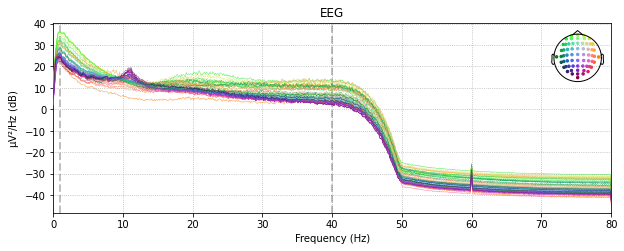

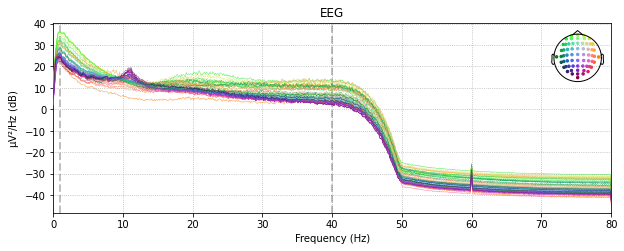

In [81]:
eeg.raw.plot_psd()

## Prepare Data

In [18]:
X, y = eeg.get_X_y()

print(X.shape, y.shape)

X = X[:, np.newaxis,:,:]
X.shape

(900, 64, 161) (900,)


(900, 1, 64, 161)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape, y_train.shape)

(630, 1, 64, 161) (630,)


In [20]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 32

def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    dl = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)
    return dl
train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

In [21]:
for i, (images, label) in enumerate(train_loader):
    print(images.shape)
    break

torch.Size([32, 1, 64, 161])


## Model and evaluation

In [23]:
torch.cuda.is_available()

False

In [24]:
#set gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [75]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        #using sequential helps bind multiple operations together
        self.layer1 = nn.Sequential(
            #in_channel = 1
            #out_channel = 16
            #padding = (kernel_size - 1) / 2 = 2
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #after layer 1 will be of shape [32, 16, 32, 80]
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #after layer 2 will be of shape [100, 32, 16, 40]
        self.fc = nn.Linear(128*16*40, 2)
        self.drop_out = nn.Dropout(0.5)  #zeroed 0.2% data
        #after fc will be of shape [100, 10]
        
    def forward(self, x):
        #x shape: [batch, in_channel, img_width, img_height]
        #[32, 1, 64, 161]

        out = self.layer1(x)
        out = self.drop_out(out)
        #after layer 1: shape: [32, 16, 32, 80]
        
        out = self.layer2(out)
        out = self.drop_out(out)
        #after layer 2: shape: [100, 32, 16, 40]
        
        out = out.reshape(out.size(0), -1)   #can also use .view()
        #after squeezing: shape: [32, 20480]
        #we squeeze so that it can be inputted into the fc layer
        
        out = self.fc(out)
        #after fc layer: shape: [32, 2]
        return out

In [76]:
model = ConvNet().to(device)

In [77]:
model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=81920, out_features=2, bias=True)
  (drop_out): Dropout(p=0.5, inplace=False)
)

In [82]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model

The model ConvNet has 370,818 trainable parameters


In [78]:
# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

### Training

In [83]:
# Train the model
num_epochs = 100
train_acc = []
train_losses = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    for i, (images, labels) in enumerate(train_loader):
        
        #con2d expects (batch, channel, width, height)
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        _, predicted = torch.max(outputs.data, 1)
        total_loss += loss.item()
        correct += (predicted == labels).sum().item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if (i+1) % 1 == 0:
            sys.stdout.write ('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    train_acc.append(100 * correct / len(train_loader.dataset))
    train_losses.append(total_loss / len(train_loader))

Epoch [36/100], Step [20/20], Loss: 0.3755

KeyboardInterrupt: 

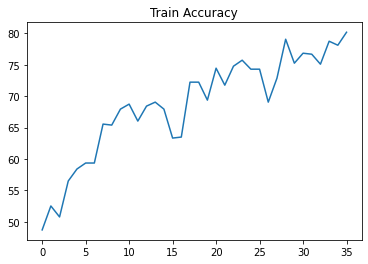

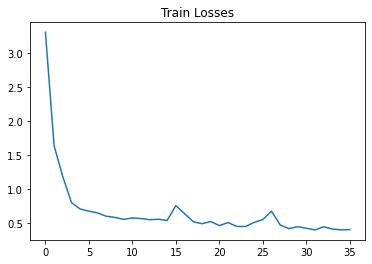

In [84]:
plt.plot(train_acc, label='train')
plt.title('Train Accuracy')
plt.show()
plt.plot(train_losses, label='train')
plt.title('Train Losses')
plt.show()

### Testing

In [85]:
# Test the model
model.eval()  # eval mode will turn off the dropout; good to explicitly call when you test
all_labels = []
all_predicted = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.append(labels.cpu().numpy())  #for plotting
        all_predicted.append(predicted.cpu().numpy())

    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

Test Accuracy of the model: 52.22222222222222 %


In [58]:
all_labels

[array([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 1], dtype=int64),
 array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 1], dtype=int64),
 array([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 1, 0, 1], dtype=int64),
 array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 0, 0], dtype=int64),
 array([1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 1, 0, 0], dtype=int64),
 array([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 1], dtype=int64),
 array([0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 1], dtype=int64),
 array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 0, 1]

In [59]:
all_predicted

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]